In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

#data processing
import re, string
import nltk
import sklearn
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import RobertaModel, RobertaTokenizer

import torch
from torch.utils.data import DataLoader, Dataset

#sdv
from sdv.evaluation import evaluate
from sdv.metrics.tabular import CSTest, KSTest, LogisticDetection, SVCDetection
from sdv.tabular import CTGAN, TVAE, CopulaGAN, GaussianCopula

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

2023-06-09 11:27:59.519707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martagracia/Library/Python/3.9/lib/python/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/martagracia/Library/Python/3.9/lib/python/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import joblib
import re
import string

from nltk.corpus import stopwords
from datetime import datetime
from apyori import apriori
import lxml.etree as ET
import pandas as pd
import numpy as np
import unidecode
import html
import os
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Define paths

In [3]:
NEWS_PATH = '../data/news/'

# Create data

In [4]:
def normalize_string(to_normalize, encoded = False, remove_stopwords = True):
    '''
    Normalize text given a string
    '''
    text = str(to_normalize).lower()  # lowering text
    if encoded: 
        text = ' '.join([html.unescape(term) for term in text.split()])
    text = unidecode.unidecode(text)

    text = re.sub(r'[^\w\s]', '', text)  # removing all the punctuations
    last_text = text.split()  # tokenize the text

    # remove stopwords
    stopwords_set = set()
    if remove_stopwords: stopwords_set = set(stopwords.words("spanish"))
    
    last_text = ' '.join([x for x in last_text if (x not in stopwords_set)])
    return last_text

def listdir_checked(path, unwanted = ['.DS_Store']):
    '''
    Discard unwanted files or directories when listing the elements in a given path
    '''
    return (f for f in os.listdir(path) if f not in unwanted)


def create_articles_dictionary(NEWS_PATH):
    '''
    Import articles information.
    Articles are stored in directories in the NEWS_PATH.
    '''
    data = {}               # keys: media, value: list of dictionaries with info about the news articles of the given media
    unique_urls = []        # list to store unique urls to discard repeated ones
    repeated_data = {}      # store repeated articles following the same format as 'data' dictionary

    for year in listdir_checked(NEWS_PATH):
        for month in listdir_checked(NEWS_PATH + '/' + year):
            for file in listdir_checked(NEWS_PATH + '/' + year + '/' + month):
                try:
                    full_path = NEWS_PATH + '/' + year + '/' + month + '/' + file
                    # Read xml file - info stored following NewsML-G2 format
                    root = ET.parse(full_path).getroot()
                    # Parse news
                    media = file.rsplit('_', 1)[0]
                    # Check repeated urls
                    url = root.findall(".//infoSource")[0].get("uri")
                    str_date = root.findall('.//contentMeta')[0].find('contentCreated').text[:10]
                    info = {
                        'id': file.split(':')[-1].replace('.xml', ''),
                        'media': media,
                        'publication_date': datetime.strptime(str_date, '%Y-%m-%d'),
                        'title': normalize_string(root.findall('.//itemRef')[0].find('title').text, encoded = True, remove_stopwords = False),
                        'headline': normalize_string(root.findall(".//itemRef")[0].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'article': normalize_string(root.findall('.//itemRef')[1].find('description').text.strip(), encoded = True, remove_stopwords = False),
                        'url': url
                    }

                    if url not in unique_urls:
                        unique_urls.append(url)
                        try:
                            data[media].append(info)
                        except:
                            data[media] = [info]

                    else:
                        try:
                            repeated_data[media].append(info)
                        except:
                            repeated_data[media] = [info]
                except:
                    pass
                    
    return data, repeated_data


def get_data_info(data, dict_key, value):
    '''
    Aux function to obtain the info of the articles with the given 
    value for the provided dict_key in data
    '''
    matching_elements = []
    for media, news in data.items():
        for article in news:
            if article[dict_key] == value:
                matching_elements.append(article)
    return matching_elements

In [5]:
data, repeated_data = create_articles_dictionary(NEWS_PATH)

articles_list = []

for media in data.keys():
    for new in data[media]:
        tweet_id = new['id']
        title = normalize_string(new['title'])
        headline = normalize_string(new['headline'])
        url = new['url']
        publication_date = new['publication_date']
        article = normalize_string(new['article'])
        
        articles_list.append({'tweet_id': tweet_id, 
                              'media': media, 
                              'title': title, 
                              'headline': headline, 
                              'url': url, 
                              'article': article,
                              'publication_date': publication_date})

articles_df = pd.DataFrame(articles_list)

articles_df['tweet_id'] = articles_df['tweet_id'].str.split('_').str[-1]
articles_df['media'] = articles_df['media'].str.split('_').str[0]
articles_df['tweet_id'] = articles_df['tweet_id'].astype(int)

#RENAME SOME MEDIA
articles_df['media'] = articles_df['media'].replace({'La': 'LaSER', 
                                                     'el': 'elPais',
                                                     'noticias': 'noticiascuatro',
                                                     'publico': 'diarioPublico',
                                                     'voz': 'vozpopuli'});

In [6]:
articles_df['text'] = articles_df['title'] + ' ' + articles_df['headline'] + ' ' + articles_df['article']

In [7]:
articles_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...


# Histograms

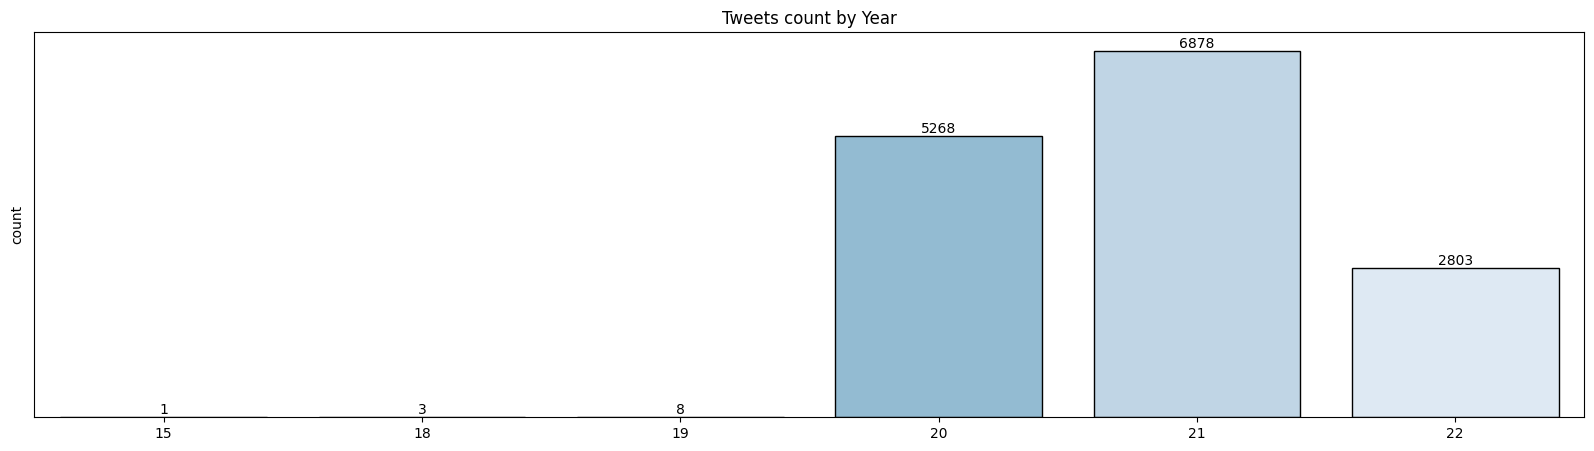

In [73]:
df = articles_df
tweets_per_year = df['publication_date'].dt.strftime('%y').value_counts().sort_index().reset_index(name='counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_year,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by Year')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show();

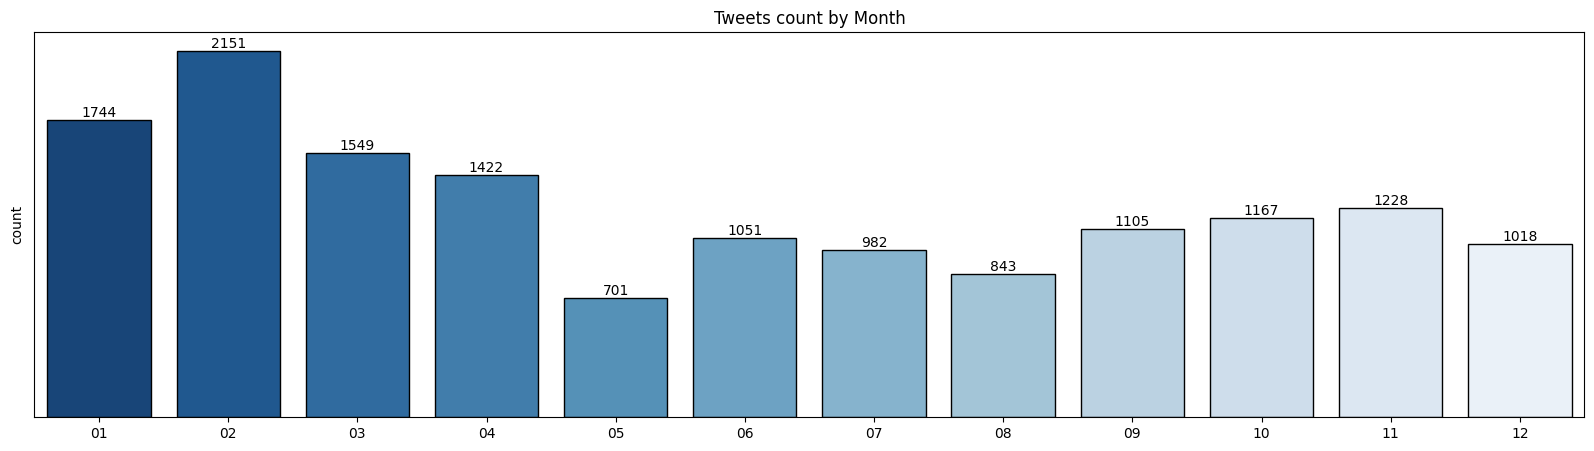

In [74]:
df = articles_df
tweets_per_month = df['publication_date'].dt.strftime('%m').value_counts().sort_index().reset_index(name='counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_month,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by Month')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show();

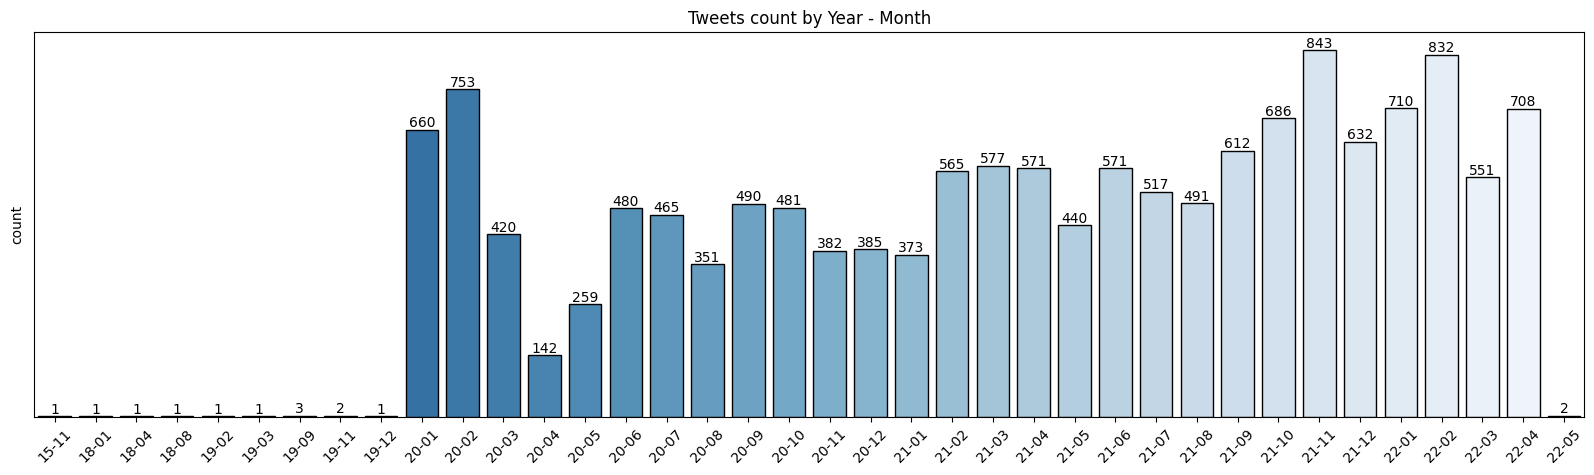

In [75]:
df = articles_df
tweets_per_yearmonth = df['publication_date'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_yearmonth,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by Year - Month')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show();

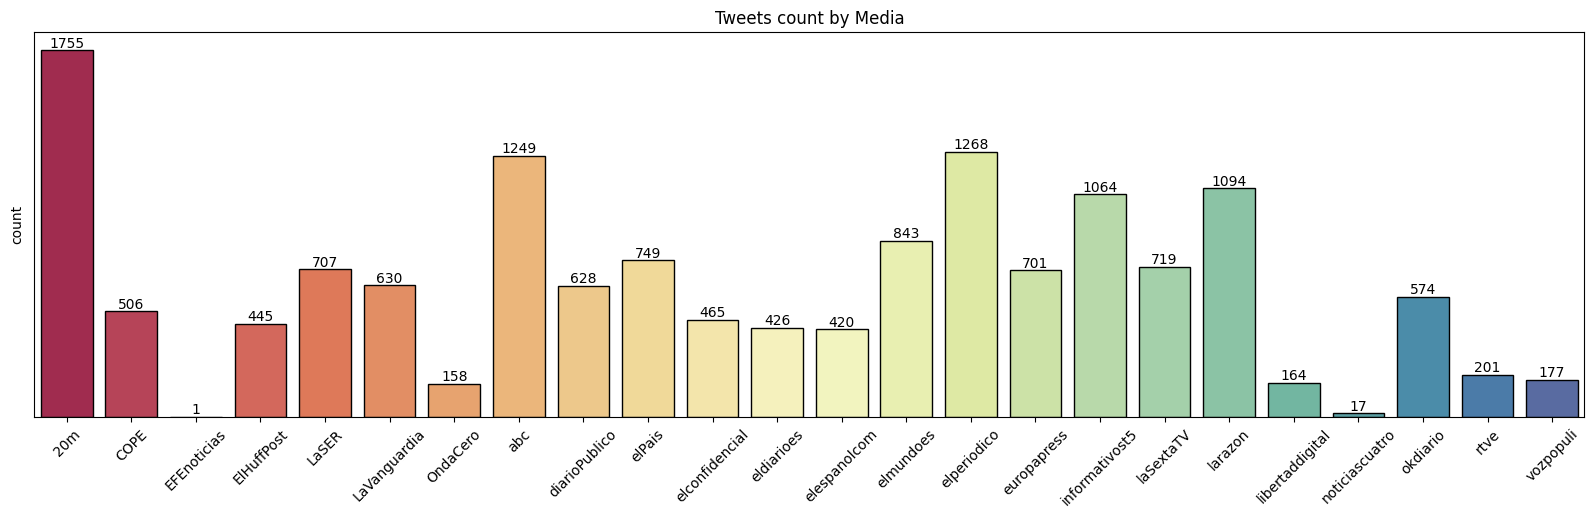

In [76]:
df = articles_df
tweets_per_media = df['media'].value_counts().sort_index().reset_index(name='counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_media,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by Media')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show();

In [77]:
df = articles_df
title_len = []
for text in articles_df['title']:
    text_len = len(text.split())
    title_len.append(text_len)
df['title_len'] = title_len

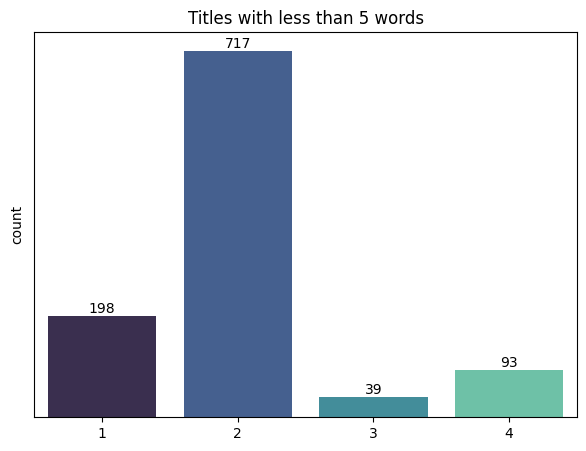

In [78]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='title_len', data=df[df['title_len']<5], palette='mako')
plt.title('Titles with less than 5 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show();

In [79]:
headline_len = []
for text in articles_df['headline']:
    text_len = len(text.split())
    headline_len.append(text_len)
df['headline_len'] = headline_len

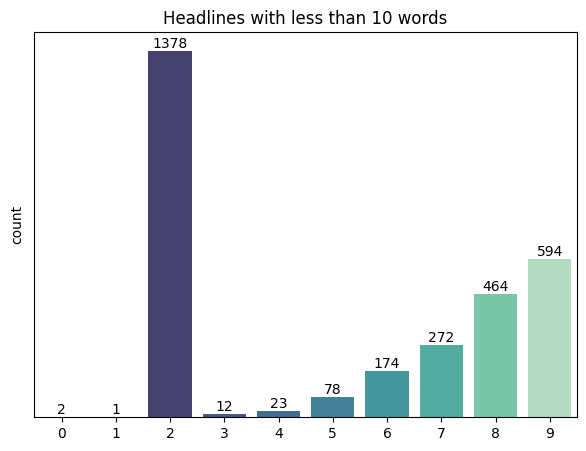

In [80]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='headline_len', data=df[df['headline_len']<10], palette='mako')
plt.title('Headlines with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show();

In [81]:
article_len = []
for text in articles_df['article']:
    text_len = len(text.split())
    article_len.append(text_len)
df['article_len'] = article_len

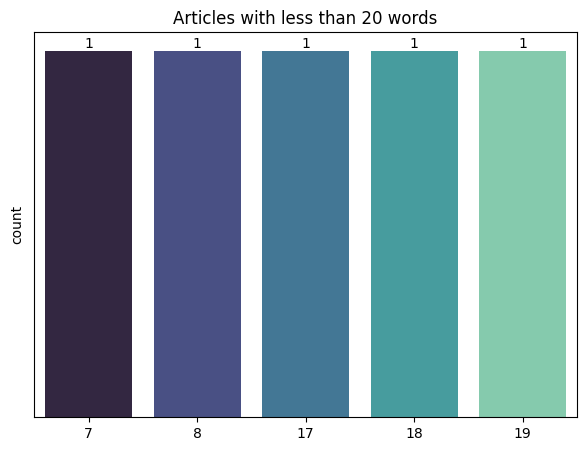

In [82]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='article_len', data=df[df['article_len']<20], palette='mako')
plt.title('Articles with less than 20 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show();

Let's perform a further cleaning checking the tokenizer version of the sentences with the articles.

# Labeled

IMPORT ARTICLES LABELED MANUALLY

In [8]:
label_df = pd.read_csv('manual_labeling_3.csv')
label_df = label_df.drop_duplicates(subset=['ID'])
label_df['ID'] = label_df['ID'].astype(str)

In [9]:
# Agregar la columna "DESCONOCIDO" con valores iniciales en 1
label_df['DESCONOCIDO'] = 1

# Actualizar los valores de "DESCONOCIDO" basados en los valores de "CONOCIDO"
label_df.loc[label_df['CONOCIDO'] == 1, 'DESCONOCIDO'] = 0

In [10]:
# Comprobación de valores contradictorios entre "CONOCIDO" y "DESCONOCIDO"
contradictory_values = label_df[(label_df['CONOCIDO'] == 1) & (label_df['DESCONOCIDO'] == 1)]
if contradictory_values.empty:
    print("No hay valores contradictorios entre 'CONOCIDO' y 'DESCONOCIDO'.")
else:
    print("Hay valores contradictorios entre 'CONOCIDO' y 'DESCONOCIDO'.")
    print(contradictory_values)


No hay valores contradictorios entre 'CONOCIDO' y 'DESCONOCIDO'.


In [11]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 899
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           890 non-null    object
 1   CONOCIDO     890 non-null    int64 
 2   PAREJA/EX    890 non-null    int64 
 3   FAMILIAR     890 non-null    int64 
 4   NUM. AGR     890 non-null    int64 
 5   DESCONOCIDO  890 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 48.7+ KB


In [12]:
articles_df.info()
articles_df['tweet_id'] = articles_df['tweet_id'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14961 entries, 0 to 14960
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          14961 non-null  int64         
 1   media             14961 non-null  object        
 2   title             14961 non-null  object        
 3   headline          14961 non-null  object        
 4   url               14961 non-null  object        
 5   article           14961 non-null  object        
 6   publication_date  14961 non-null  datetime64[ns]
 7   text              14961 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 935.2+ KB


In [13]:
# Concatenar los DataFrames basados en las columnas 'tweet_id' y 'ID'
train_label_df = pd.concat([articles_df.set_index('tweet_id'), label_df.set_index('ID')], axis=1, join='inner').reset_index()
train_label_df.rename(columns={'index': 'tweet_id'}, inplace=True)

train_label_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text,CONOCIDO,PAREJA/EX,FAMILIAR,NUM. AGR,DESCONOCIDO
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0,0,0,1,1
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,1,0,1,0,0
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0,0,0,1,1
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,1,0,0,2,0
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0,0,0,0,1


In [14]:
train_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          884 non-null    object        
 1   media             884 non-null    object        
 2   title             884 non-null    object        
 3   headline          884 non-null    object        
 4   url               884 non-null    object        
 5   article           884 non-null    object        
 6   publication_date  884 non-null    datetime64[ns]
 7   text              884 non-null    object        
 8   CONOCIDO          884 non-null    int64         
 9   PAREJA/EX         884 non-null    int64         
 10  FAMILIAR          884 non-null    int64         
 11  NUM. AGR          884 non-null    int64         
 12  DESCONOCIDO       884 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 89.9+ KB


In [15]:
# Obtener el orden deseado de las columnas
nuevas_columnas = ['tweet_id', 'media', 'title', 'headline', 'url', 'article', 'publication_date','text', 
                   'CONOCIDO', 'PAREJA/EX', 'FAMILIAR', 'DESCONOCIDO', 'NUM. AGR']

# Reordenar las columnas del DataFrame
train_label_df = train_label_df[nuevas_columnas]

In [16]:
# Crear la columna "label_relacion" con valores iniciales de 0
train_label_df['label_relacion'] = 0

# Establecer valores en la columna "label_relacion" basado en condiciones
train_label_df.loc[train_label_df['DESCONOCIDO'] == 1, 'label_relacion'] = 0
train_label_df.loc[(train_label_df['CONOCIDO'] == 1) & (train_label_df['PAREJA/EX'] == 0) & (train_label_df['FAMILIAR'] == 0) & (train_label_df['DESCONOCIDO'] == 0), 'label_relacion'] = 3
train_label_df.loc[train_label_df['PAREJA/EX'] == 1, 'label_relacion'] = 1
train_label_df.loc[train_label_df['FAMILIAR'] == 1, 'label_relacion'] = 2

In [102]:
train_label_df['label_relacion'].value_counts()

0    478
2    173
3    118
1    115
Name: label_relacion, dtype: int64

## Train val test split

In [18]:
data_train, data_test = train_test_split(train_label_df, test_size=0.2, random_state=seed)

print(data_train.shape, data_test.shape)

(707, 14) (177, 14)


Utilizar solo las columnas necesarias para optimizar

In [19]:
# train
X_train = data_train['text']
y_train = data_train['label_relacion']
train_df = data_train[['text', 'label_relacion']]

# test
X_test = data_test['text']
y_test = data_test['label_relacion']
test_df = data_test[['text', 'label_relacion']]

# Label column analysis on train

In [20]:
y_train.value_counts()

0    378
2    139
3     98
1     92
Name: label_relacion, dtype: int64

### Synthetic Data Generation: TVAE and CTGAN Models

In [21]:
model_tvae = TVAE()
model_ctgan = CTGAN()

In [97]:
model_tvae.fit(train_df)
new_data_tvae = model_tvae.sample(train_df.shape[0])
new_data_tvae.head()

,text,label_relacion
0,name prision name pago 70000 euros name name c...,0
1,name tres anos prision amenazar exmarido difun...,1
2,name tres anos prision amenazar exmarido difun...,1
3,name cantante name name violada drogada name c...,0
4,name cantante name name violada drogada name c...,0


In [98]:
model_ctgan.fit(train_df)
new_data_ctgan = model_ctgan.sample(train_df.shape[0])
new_data_ctgan.head()

,text,label_relacion
0,name acusados violacion grupal name sostienen ...,1
1,name 3 jovenes violacion 3 hermanas estadounid...,0
2,name suicida exentrenador olimpico gimnasia ee...,3
3,name name hombre tras golpear suelo name agarr...,0
4,name cuatro anos prision abusos sexuales conti...,0


In [99]:
new_data_ctgan['label_relacion'].value_counts()

0    412
1    126
3     94
2     75
Name: label_relacion, dtype: int64

Evaluation of the model

In [100]:
metrics = ["CSTest", "KSTest"]

In [101]:
evaluate(
    new_data_tvae,
    train_df,
)

0.6539586707043734

In [102]:
evaluate(
    new_data_ctgan,
    train_df
)

0.921964326734984

In [22]:
#new_data_ctgan.to_csv('synthetic_data_ctgan.csv')
new_data_ctgan = pd.read_csv('synthetic_data_ctgan.csv')

In [23]:
new_data_ctgan['label_relacion'].value_counts()

0    412
1    126
3     94
2     75
Name: label_relacion, dtype: int64

ctgan modelos mas de tablas, modelo tvae mas de texto libre

### Juntamos datos reales y sinteticos

In [24]:
data_train_all = pd.concat([train_df, new_data_ctgan], ignore_index=True)

In [25]:
X_train = data_train_all['text']
y_train = data_train_all['label_relacion']

In [26]:
y_train.value_counts()

0    790
1    218
2    214
3    192
Name: label_relacion, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

Tenemos los datos super unbalanced, aplicaremos oversampling

"Si el rendimiento y la capacidad de detección de la clase minoritaria son importantes, puede ser recomendable utilizar oversampling para generar más instancias sintéticas de la clase minoritaria y equilibrar la distribución de clases. Esto permitiría al modelo aprender y capturar mejor las características de la clase minoritaria."

In [27]:
# Aplicar undersampling en la clase mayoritaria (clase 0)
rus = RandomUnderSampler(sampling_strategy={0: 500})
undersampled_x, undersampled_y = rus.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

# Aplicar oversampling en las clases minoritarias (clases 1, 2 y 3)
ros = RandomOverSampler(sampling_strategy={2: 350, 1: 250, 3: 250})
oversampled_x, oversampled_y = ros.fit_resample(np.array(undersampled_x).reshape(-1, 1), np.array(undersampled_y).reshape(-1, 1))
train_data = pd.DataFrame(list(zip([x[0] for x in oversampled_x], oversampled_y)), columns=['text', 'label_relacion'])

In [28]:
train_data['label_relacion'].value_counts()

0    500
2    350
1    250
3    250
Name: label_relacion, dtype: int64

In [29]:
train_data.head()

,text,label_relacion
0,name hombre abusar sexualmente hija menor pare...,0
1,name depravadas practicas menores costado 19 a...,0
2,name acusado abusar nieta expareja dice nunca ...,0
3,actor goonies denuncia name name violo nino 13...,0
4,name name queda libertad despues hermana pagar...,0


One hot encoding in Train, Val and Test

In [30]:
ohe = preprocessing.OneHotEncoder()
y_train_ohe = ohe.fit_transform(np.array(train_data['label_relacion']).reshape(-1, 1)).toarray()
y_test_ohe = ohe.fit_transform(np.array(test_df['label_relacion']).reshape(-1, 1)).toarray()

# tokenizer

First, we import the BERT tokenizer.

In [31]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

In [113]:
token_lens = []

for txt in train_data['text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [114]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 512


In [115]:
train_data['token_lens'] = token_lens

In [116]:
train_data['token_lens'].value_counts()

512    221
249     17
152     16
336     14
172     12
442     12
204     12
456     11
329     11
367     11
171     11
62      11
166     10
323     10
161     10
270     10
424     10
246     10
370     10
250     10
319     10
278      9
342      9
347      9
145      9
511      9
288      9
212      9
174      8
181      8
188      8
451      8
122      8
298      8
191      8
296      8
355      8
194      8
265      8
200      7
150      7
186      7
182      7
348      7
202      7
142      7
175      7
361      7
167      7
449      7
147      7
201      7
241      7
207      7
362      7
284      7
206      7
409      7
134      6
210      6
165      6
180      6
252      6
253      6
120      6
193      6
259      6
219      6
315      6
262      6
187      6
282      5
359      5
144      5
244      5
240      5
503      5
138      5
197      5
381      5
358      5
101      5
68       5
294      5
208      5
159      5
303      5
275      5
157      5
243      5
334      4

EN LOS ARTICULOS LA INFORMACIÓN MÁS RELEVANTE SIEMPLE ESTA EN EL TITULO, EN EL HEADLINE O AL INICIO DEL ARTICULO EN SI, POR ESO CONSIDERAMOS LA OPCIÓN DE TOKENIZAR POR UN MAXIMO DE 512 Y TODO LO OTRO HACER TRUNCACION Y ELIMINARLO

In [34]:
MAX_LEN = 250

In [35]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [36]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [37]:
train_input_ids, train_attention_masks = tokenize(train_data['text'], MAX_LEN)
test_input_ids, test_attention_masks = tokenize(test_df['text'], MAX_LEN)

# BERT Modeling

In [38]:
bert_model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def create_model(bert_model, max_len=MAX_LEN):
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(4, activation="softmax")(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [46]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109850880   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 250,                                         

In [47]:
#model.fit([train_input_ids,train_attention_masks], y_train_ohe, epochs=4, batch_size=16)  

Epoch 1/4
85/85 [==============================] - 3864s 45s/step - loss: 0.9941 - categorical_accuracy: 0.6007
Epoch 2/4
85/85 [==============================] - 3909s 46s/step - loss: 0.8867 - categorical_accuracy: 0.6541
Epoch 3/4
85/85 [==============================] - 3953s 47s/step - loss: 0.8064 - categorical_accuracy: 0.6674
Epoch 4/4
85/85 [==============================] - 3917s 46s/step - loss: 0.7608 - categorical_accuracy: 0.6867


In [48]:
#result_bert = model.predict([test_input_ids,test_attention_masks])

6/6 [==============================] - 122s 19s/step


In [49]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1
result_berttt = pd.DataFrame(result_bert)
result_berttt.to_csv('result_bert.csv')
y_pred_bertberttt = pd.DataFrame(y_pred_bert)
y_pred_bertberttt.to_csv('y_pred_bert.csv')

### BERT Results

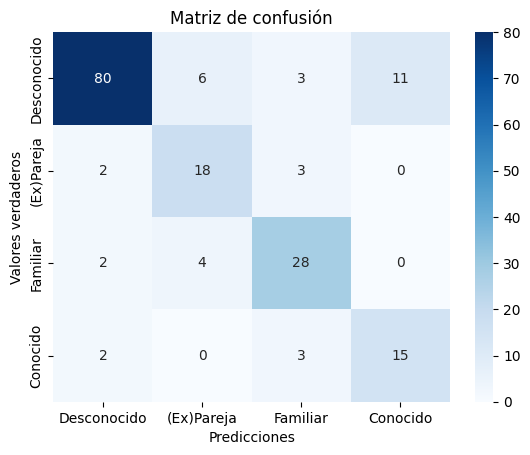

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtén la matriz de confusión
cm = confusion_matrix(y_test_ohe.argmax(axis=1), y_pred_bert.argmax(axis=1))

# Define las etiquetas de las clases
labels = ['Desconocido', '(Ex)Pareja', 'Familiar', 'Conocido']

# Crea el mapa de calor utilizando seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

# Configura las etiquetas de los ejes y el título
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de confusión')

# Muestra el mapa de calor
plt.show()


In [121]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_ohe,y_pred_bert, target_names=['Desconocido', '(Ex)Pareja', 'Familiar', 'Conocido']))

	Classification Report for BERT:

               precision    recall  f1-score   support

 Desconocido       0.93      0.80      0.86       100
  (Ex)Pareja       0.64      0.78      0.71        23
    Familiar       0.76      0.82      0.79        34
    Conocido       0.58      0.75      0.65        20

   micro avg       0.80      0.80      0.80       177
   macro avg       0.73      0.79      0.75       177
weighted avg       0.82      0.80      0.80       177
 samples avg       0.80      0.80      0.80       177



Con base en la matriz de confusión y el informe de clasificación proporcionados, podemos obtener las siguientes conclusiones:

1. Precisión (Precision): La precisión de la clase 0 (Class 0) es del 81%, lo que significa que el 81% de las muestras clasificadas como clase 0 son realmente de esa clase. La precisión de las clases 1 (Class 1), 2 (Class 2) y 3 (Class 3) es del 73%, 100% y 80% respectivamente.

2. Sensibilidad o Tasa de Verdaderos Positivos (Recall o True Positive Rate): La sensibilidad de la clase 0 es del 93%, lo que indica que el 93% de las muestras verdaderamente pertenecientes a la clase 0 se clasificaron correctamente. La sensibilidad de las clases 1, 2 y 3 es del 80%, 77% y 57% respectivamente.

3. Valor F1 (F1-Score): El valor F1 de la clase 0 es del 86%, lo que combina la precisión y la sensibilidad en una medida única. Los valores F1 de las clases 1, 2 y 3 son del 76%, 87% y 67% respectivamente.

4. Exactitud (Accuracy): La exactitud general del modelo es del 84%, lo que indica que el 84% de las muestras se clasificaron correctamente en general.

5. La matriz de confusión muestra la distribución de las clasificaciones correctas e incorrectas en cada clase. Por ejemplo, la clase 0 tiene 38 muestras clasificadas correctamente, 2 muestras clasificadas incorrectamente como clase 1, 0 muestras clasificadas incorrectamente como clase 2 y 1 muestra clasificada incorrectamente como clase 3.

En resumen, se puede concluir que el modelo BERT tiene un rendimiento razonablemente bueno, con altas precisiones y sensibilidades en la mayoría de las clases. Sin embargo, la clase 3 muestra una sensibilidad más baja, lo que indica que el modelo tiene dificultades para detectar correctamente las muestras de esa clase. Esto se refuerza por el valor F1 más bajo de la clase 3 en comparación con las otras clases. Es importante evaluar el rendimiento del modelo en función de los objetivos y requisitos específicos del problema en cuestión.

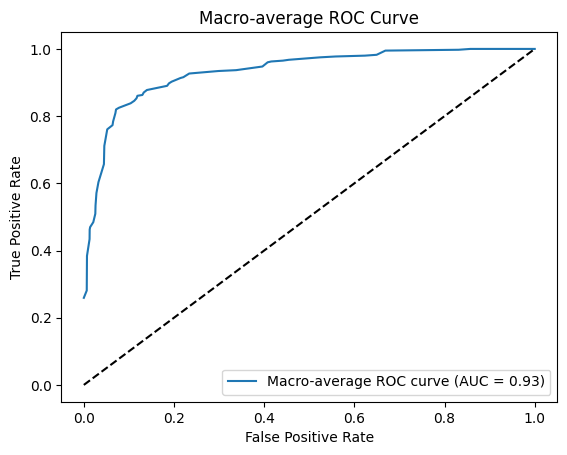

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def macro_roc_curve(y_true, y_scores):
    # Calcula la curva ROC y el área bajo la curva (AUC) para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_scores.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcula el promedio de los valores de TPR y FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    # Calcula el promedio del AUC
    mean_auc = np.mean(list(roc_auc.values()))

    # Construye la curva ROC con los valores promediados
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = mean_auc

    return fpr, tpr, roc_auc

# Ejemplo de uso
# y_true: etiquetas verdaderas de forma (n_samples, n_classes)
# y_scores: probabilidades de predicción de forma (n_samples, n_classes)
y_true = y_test_ohe
y_scores = result_bert
fpr, tpr, roc_auc = macro_roc_curve(y_true, y_scores)

# Visualiza la curva ROC promediada
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc["macro"]))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [123]:
def plot_roc_curves(y_true, y_scores):
    # Calcula la curva ROC y el área bajo la curva (AUC) para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_scores.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Construye y muestra la curva ROC para la clase i
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Class {}'.format(i))
        plt.legend(loc='lower right')
        plt.show()

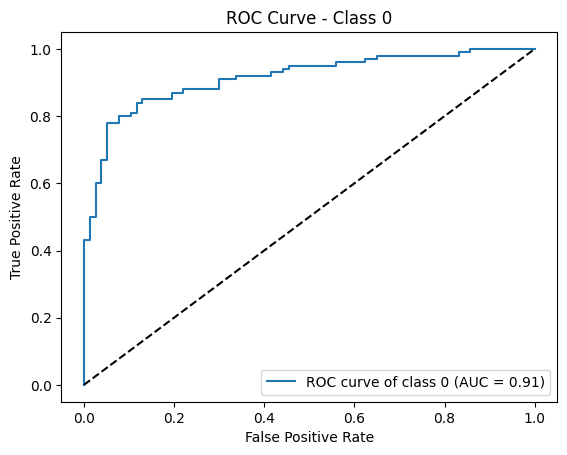

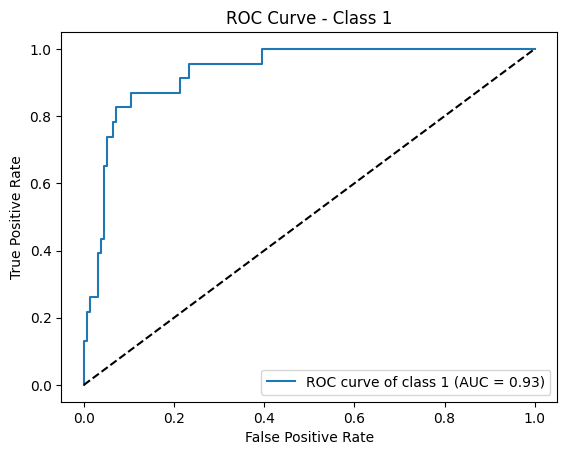

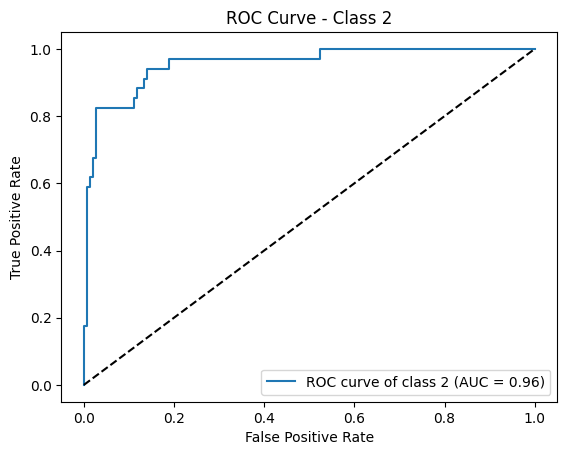

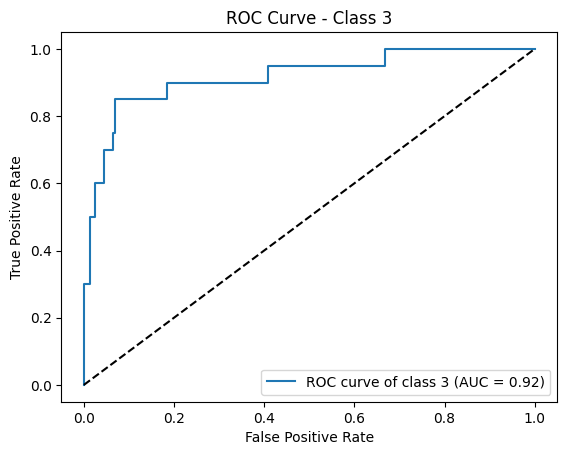

In [54]:
y_true = y_test_ohe
y_scores = result_bert
plot_roc_curves(y_true, y_scores)

# Predict label all articles

In [55]:
# Preprocess unlabeled data
articles_input_ids, articles_attention_masks = tokenize(articles_df['text'], MAX_LEN)

# Predict labels for unlabeled data
articles_predictions = model.predict([articles_input_ids, articles_attention_masks])

468/468 [==============================] - 10322s 22s/step


In [96]:
#np.save('articles_predictions_rel', articles_predictions)

In [95]:
articles_predictions

array([[0.90627235, 0.05822197, 0.01815106, 0.01735471],
       [0.05854504, 0.08466425, 0.8371647 , 0.01962603],
       [0.9049774 , 0.0302871 , 0.04071457, 0.02402088],
       ...,
       [0.89665556, 0.08230773, 0.00480685, 0.01622995],
       [0.8447204 , 0.08227608, 0.06302602, 0.00997747],
       [0.64118266, 0.06078894, 0.11067913, 0.1873493 ]], dtype=float32)

In [135]:
articles_pred_df = pd.DataFrame(articles_predictions)
articles_pred_df = articles_pred_df.rename(columns={0: 'prob_desc', 1: 'prob_pareja', 2: 'prob_familiar', 3: 'prob_conocido'})
articles_pred_df['label_predict'] = np.argmax(articles_pred_df.values, axis=1)
articles_pred_df.head()

,prob_desc,prob_pareja,prob_familiar,prob_conocido,label_predict
0,0.906272,0.058222,0.018151,0.017355,0
1,0.058545,0.084664,0.837165,0.019626,2
2,0.904977,0.030287,0.040715,0.024021,0
3,0.106185,0.046487,0.028328,0.819001,3
4,0.589247,0.375221,0.024869,0.010662,0


In [139]:
concatenated_df = pd.concat([articles_df, articles_pred_df], axis=1)
concatenated_df.head()

,tweet_id,media,title,headline,url,article,publication_date,text,prob_desc,prob_pareja,prob_familiar,prob_conocido,label_predict
0,1212203735650328577,20m,name britanica detenida falso testimonio tras ...,name joven britanica 19 anos mes julio detenida,https://www.20minutos.es/noticia/4102525/0/cul...,name joven britanica 19 anos mes julio detenid...,2019-12-31,name britanica detenida falso testimonio tras ...,0.906272,0.058222,0.018151,0.017355,0
1,1212467642428280832,20m,name parto nina 13 anos violada padre,name name nina brasilena 13 anos fallecio comi...,https://www.20minutos.es/noticia/4103250/0/mue...,name name nina brasilena 13 anos fallecio comi...,2020-01-01,name parto nina 13 anos violada padre name nam...,0.058545,0.084664,0.837165,0.019626,2
2,1212826760234127360,20m,name 3 jovenes acusados violar 3 hermanas esta...,name name name detenido jueves tres jovenes ac...,https://www.20minutos.es/noticia/4104199/0/det...,name name name detenido jueves tres jovenes ac...,2020-01-02,name 3 jovenes acusados violar 3 hermanas esta...,0.904977,0.030287,0.040715,0.024021,0
3,1213232973715267584,20m,name claves name juicio name name abusos sexua...,name juicio supuestos abusos sexuales todopode...,https://www.20minutos.es/noticia/4105188/0/cla...,name juicio supuestos abusos sexuales todopode...,2020-01-03,name claves name juicio name name abusos sexua...,0.106185,0.046487,0.028328,0.819001,3
4,1213348259076415488,20m,name name name investiga escritor frances name...,name name name abierto viernes investigacion e...,https://www.20minutos.es/noticia/4104916/0/fra...,name name name abierto viernes investigacion e...,2020-01-03,name name name investiga escritor frances name...,0.589247,0.375221,0.024869,0.010662,0


In [141]:
concatenated_df['label_predict'].value_counts()

0    9183
3    3266
2    1477
1    1035
Name: label_predict, dtype: int64

In [140]:
#concatenated_df.to_csv('articles_rel_proba.csv')